In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, datetime
import numpy as np
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from lightgbm import LGBMClassifier
import numpy as np

pd.set_option("display.max_columns", 100)

In [6]:
base_data = pd.read_csv("kaggle_dataset.csv")
base_data.head(1)

,Unnamed: 0,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
0,0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,45,28-Feb-97,1997,84,4,2,0,0,0,0,N,Y,NaN,28-Feb-99,60000.0,0.0,P I F,0.0,60000.0,48000.0,Retail_trade


In [9]:
data = base_data[["State", "ApprovalFY", "Term", "NoEmp", "UrbanRural", "NAICS", "GrAppv", "MIS_Status", "SBA_Appv", "FranchiseCode", "LowDoc"]]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, data["MIS_Status"], test_size=0.1, random_state=42, stratify=data["MIS_Status"])

X_train = X_train.drop("MIS_Status", axis=1)
X_test = X_test.drop("MIS_Status", axis=1)


In [11]:
preprocessor = make_pipeline(make_column_transformer((OneHotEncoder(), ["State", "LowDoc"]),remainder="passthrough"))

In [12]:
model = make_pipeline(preprocessor, RandomForestClassifier(10, max_depth=5, random_state=42))

model.fit(X_train, y_train)



/home/s-thorez/Documents/brief_loan/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(),
                                                                   ['State',
                                                                    'LowDoc'])]))])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, n_estimators=10,
                                        random_state=42))])

In [13]:
y_pred = model.predict(X_test)


In [14]:
y_pred_encoded = []
for y in y_pred:
    if y == "P I F":
        y_pred_encoded.append(1)
    else :
        y_pred_encoded.append(0)


In [15]:
probabilities = model.predict_proba(X_test)[:,1]

In [16]:
print("Train score : ", model.score(X_train, y_train))
print("Test score : ", model.score(X_test, y_test))
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_encoded))

print("F1-Score : ", f1_score(y_test, y_pred, pos_label="P I F"))

Train score :  0.800177284630235
Test score :  0.8003397557199381
ROC-AUC score : 0.532330736301453
F1-Score :  0.8873302673251708


In [17]:
print(classification_report(y_test, y_pred=y_pred))

              precision    recall  f1-score   support

      CHGOFF       0.90      0.07      0.12      9873
       P I F       0.80      1.00      0.89     36631

    accuracy                           0.80     46504
   macro avg       0.85      0.53      0.51     46504
weighted avg       0.82      0.80      0.73     46504



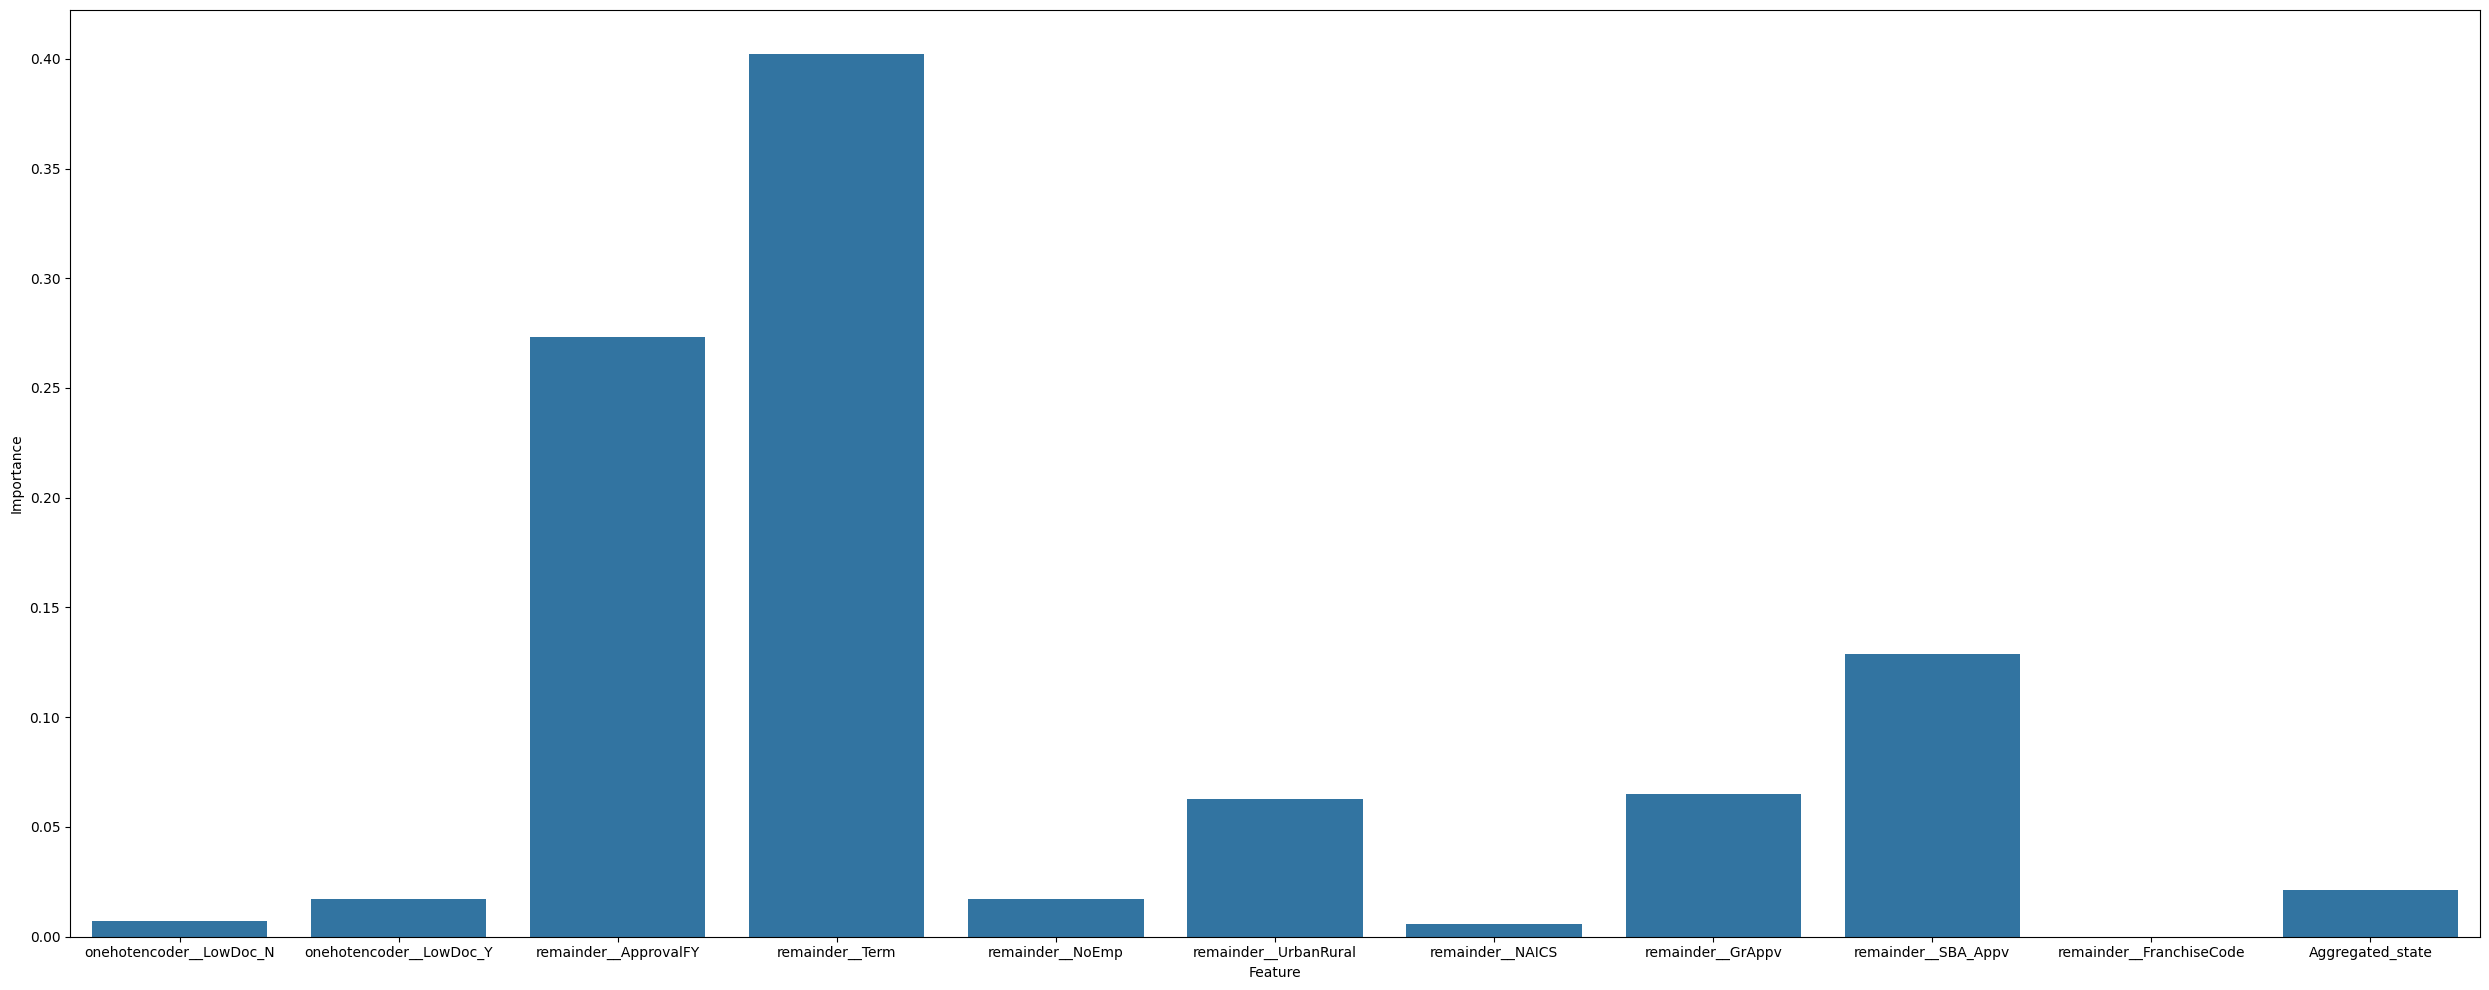

In [18]:
feature_names = model[0].get_feature_names_out()  # Extract feature names
importances = model[-1].feature_importances_  # Extract importance values

# Create a DataFrame
df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Separate features containing "state" and those that don't
df_state = df[df["Feature"].str.contains("State", case=False, na=False)]
df_other = df[~df["Feature"].str.contains("State", case=False, na=False)]

# Aggregate "state" features into a single row
aggregated_row = pd.DataFrame([{"Feature": "Aggregated_state", "Importance": df_state["Importance"].sum()}])

# Combine back the aggregated row with other features
df_final = pd.concat([df_other, aggregated_row], ignore_index=True)
plt.figure(figsize=(25, 10))
sns.barplot(df_final, x="Feature", y="Importance")
plt.tight_layout()
plt.show()

In [19]:
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

X_train_lgb[["State", "LowDoc"]] = X_train_lgb[["State", "LowDoc"]].astype("category")
X_test_lgb[["State", "LowDoc"]] = X_test_lgb[["State", "LowDoc"]].astype("category")



In [20]:
lgb = LGBMClassifier(learning_rate=0.5, n_estimators=100, max_depth=5)

lgb.fit(X_train_lgb, y_train)

[LightGBM] [Info] Number of positive: 329684, number of negative: 88852
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 418536, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787708 -> initscore=1.311163
[LightGBM] [Info] Start training from score 1.311163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMClassifier(learning_rate=0.5, max_depth=5)

In [21]:
# cat_b = CatBoostClassifier()
# cat_b.fit(X_test_lgb, y_train)

In [22]:
print("Train score : ", lgb.score(X_train_lgb, y_train))
print("Test score : ", lgb.score(X_test_lgb, y_test))
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_encoded))

print("F1-Score : ", f1_score(y_test, y_pred, pos_label="P I F"))

Train score :  0.9542691668100235
Test score :  0.9485635644245656
ROC-AUC score : 0.532330736301453
F1-Score :  0.8873302673251708


In [23]:
print("Train score : ", lgb.score(X_train_lgb, y_train))
print("Test score : ", lgb.score(X_test_lgb, y_test))
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_encoded))

print("F1-Score : ", f1_score(y_test, y_pred, pos_label="P I F"))

Train score :  0.9542691668100235
Test score :  0.9485635644245656
ROC-AUC score : 0.532330736301453
F1-Score :  0.8873302673251708


In [24]:
lgb.get_params()



{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.5,
 'max_depth': 5,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [25]:
param = {
    "learning_rate": np.linspace(0, 1, 11),
    "max_depth": [x for x in range(1, 6, 1)],
    "n_estimators": [x for x in range(10, 101, 10)]  
}

In [26]:
# search = RandomizedSearchCV(lgb, param, n_iter=100, scoring='f1_macro')

# search_grid = search.fit(X_train_lgb, y_train)



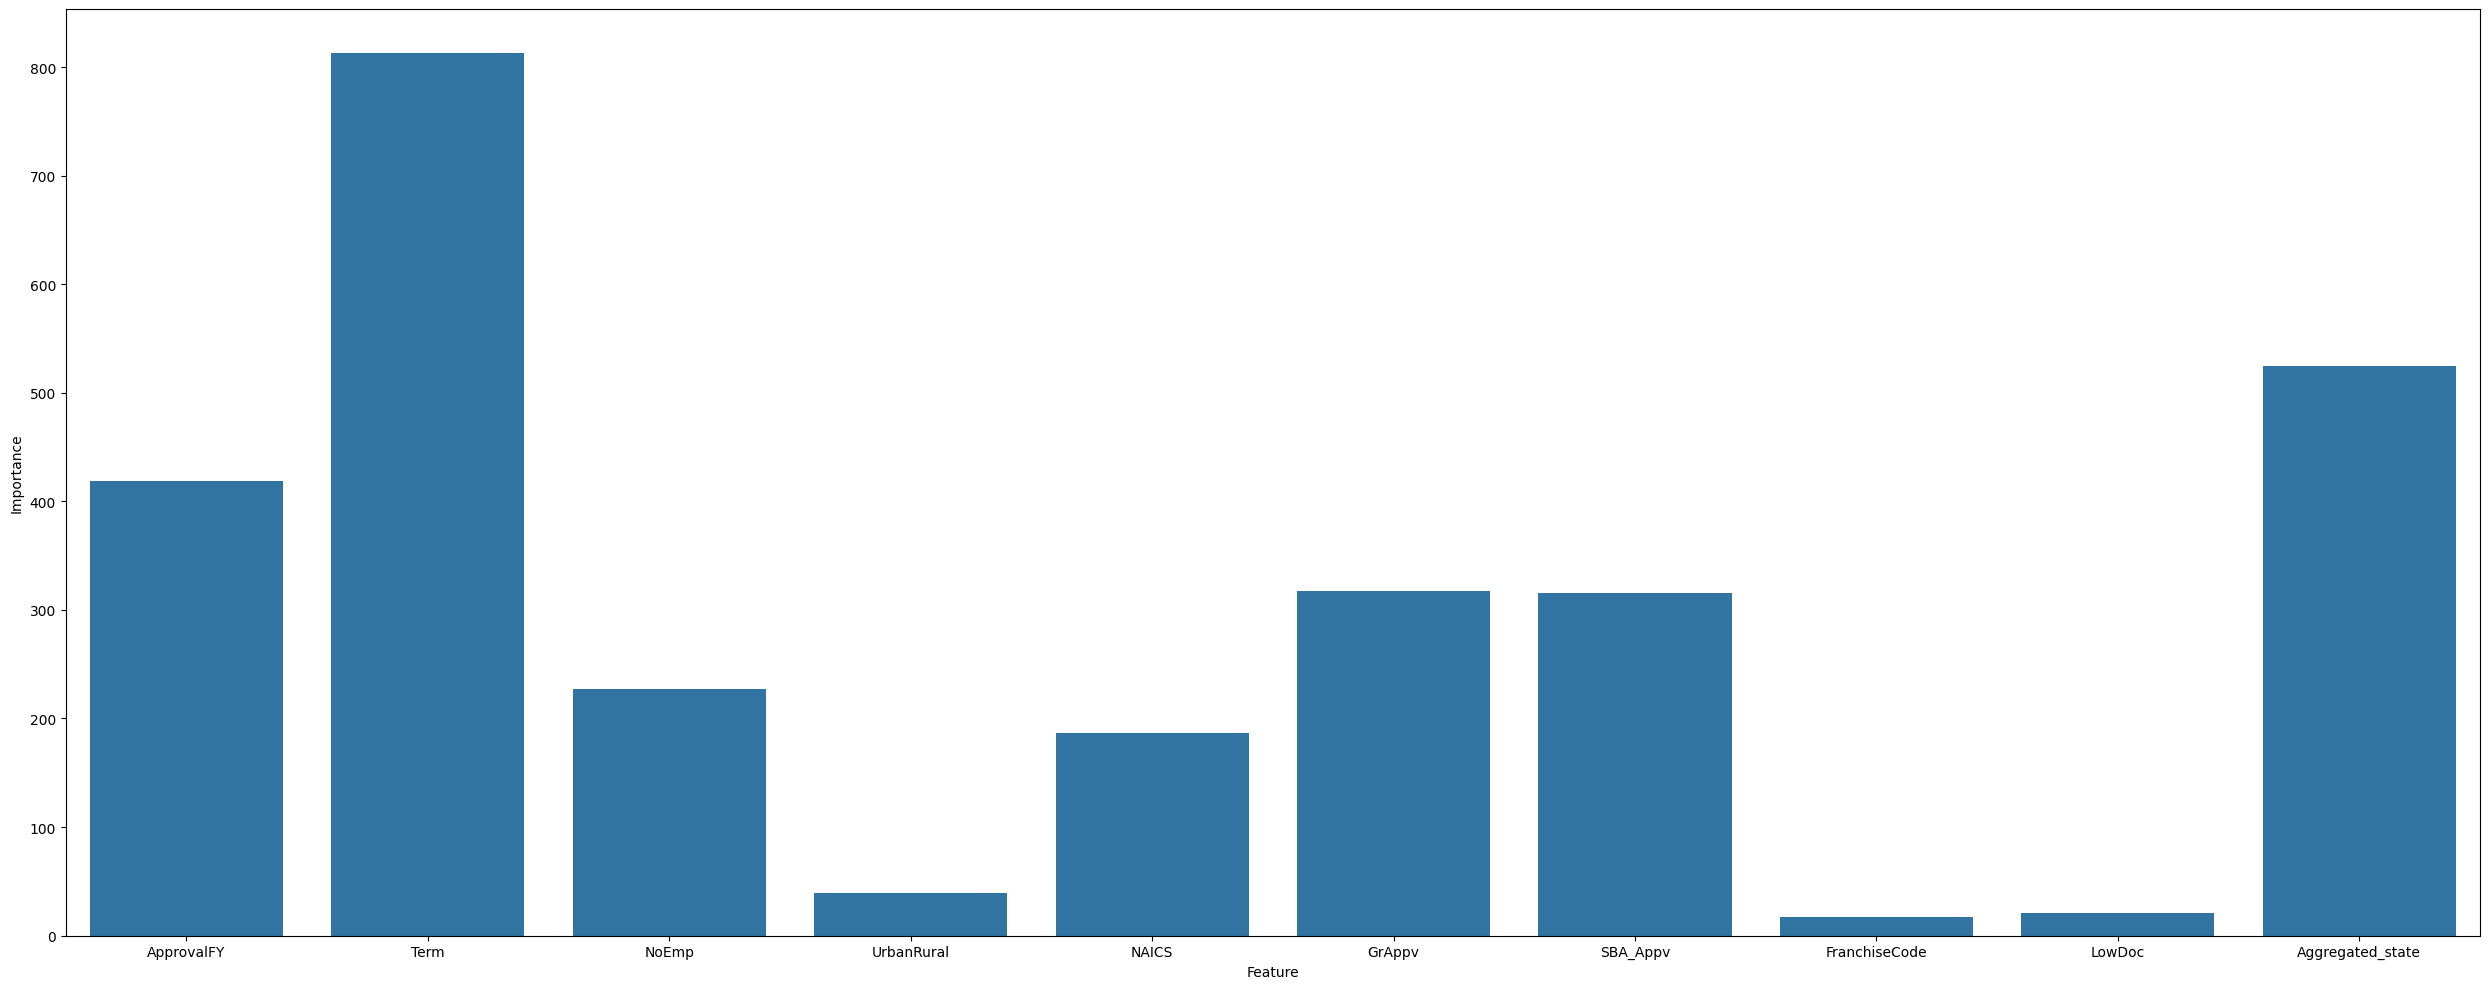

In [27]:

boost = lgb.booster_

feature_names = boost.feature_name()  # Extract feature names
importances = lgb.feature_importances_  # Extract importance values

# Create a DataFrame
df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Separate features containing "state" and those that don't
df_state = df[df["Feature"].str.contains("State", case=False, na=False)]
df_other = df[~df["Feature"].str.contains("State", case=False, na=False)]

# Aggregate "state" features into a single row
aggregated_row = pd.DataFrame([{"Feature": "Aggregated_state", "Importance": df_state["Importance"].sum()}])

# Combine back the aggregated row with other features
df_final = pd.concat([df_other, aggregated_row], ignore_index=True)
plt.figure(figsize=(25, 10))
sns.barplot(df_final, x="Feature", y="Importance")
plt.tight_layout()
plt.show()

In [28]:
print(search_grid.best_params_)

NameError: name 'search_grid' is not defined